In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText
from transformers.image_utils import load_image
import os
import json
import random

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
model_id = "LiquidAI/LFM2-VL-1.6B"
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    device_map="auto",
    dtype="bfloat16",
    trust_remote_code=True
);
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True);

`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of the model checkpoint at LiquidAI/LFM2-VL-1.6B were not used when initializing Lfm2VlForConditionalGeneration: ['model.vision_tower.vision_model.encoder.layers.25.layer_norm1.bias', 'model.vision_tower.vision_model.encoder.layers.25.layer_norm1.weight', 'model.vision_tower.vision_model.encoder.layers.25.layer_norm2.bias', 'model.vision_tower.vision_model.encoder.layers.25.layer_norm2.weight', 'model.vision_tower.vision_model.encoder.layers.25.mlp.fc1.bias', 'model.vision_tower.vision_model.encoder.layers.25.mlp.fc1.weight', 'model.vision_tower.vision_model.encoder.layers.25.mlp.fc2.bias', 'model.vision_tower.vision_model.encoder.layers.25.mlp.fc2.weight', 'model.vision_tower.vision_model.encoder.layers.25.self_attn.k_proj.bias', 'model.vision_tower.vision_model.encoder.layers.25.self_attn.k_proj.weight', 'model.vision_tower.vision_model.encoder.layers.25.self_attn.out_proj.bias', 'model.vision_tower.vision_model.encoder.l

In [4]:
mode = "train"

image_folder = f"SROIE2019/{mode}/img"
entities_folder = f"SROIE2019/{mode}/entities"

image_names = [os.path.splitext(f)[0] for f in os.listdir(image_folder) if f.endswith('.jpg')]

image_ext = ".jpg"
entities_ext = ".txt"
rand_int = random.randint(0, len(image_names))
image_name = image_names[rand_int]

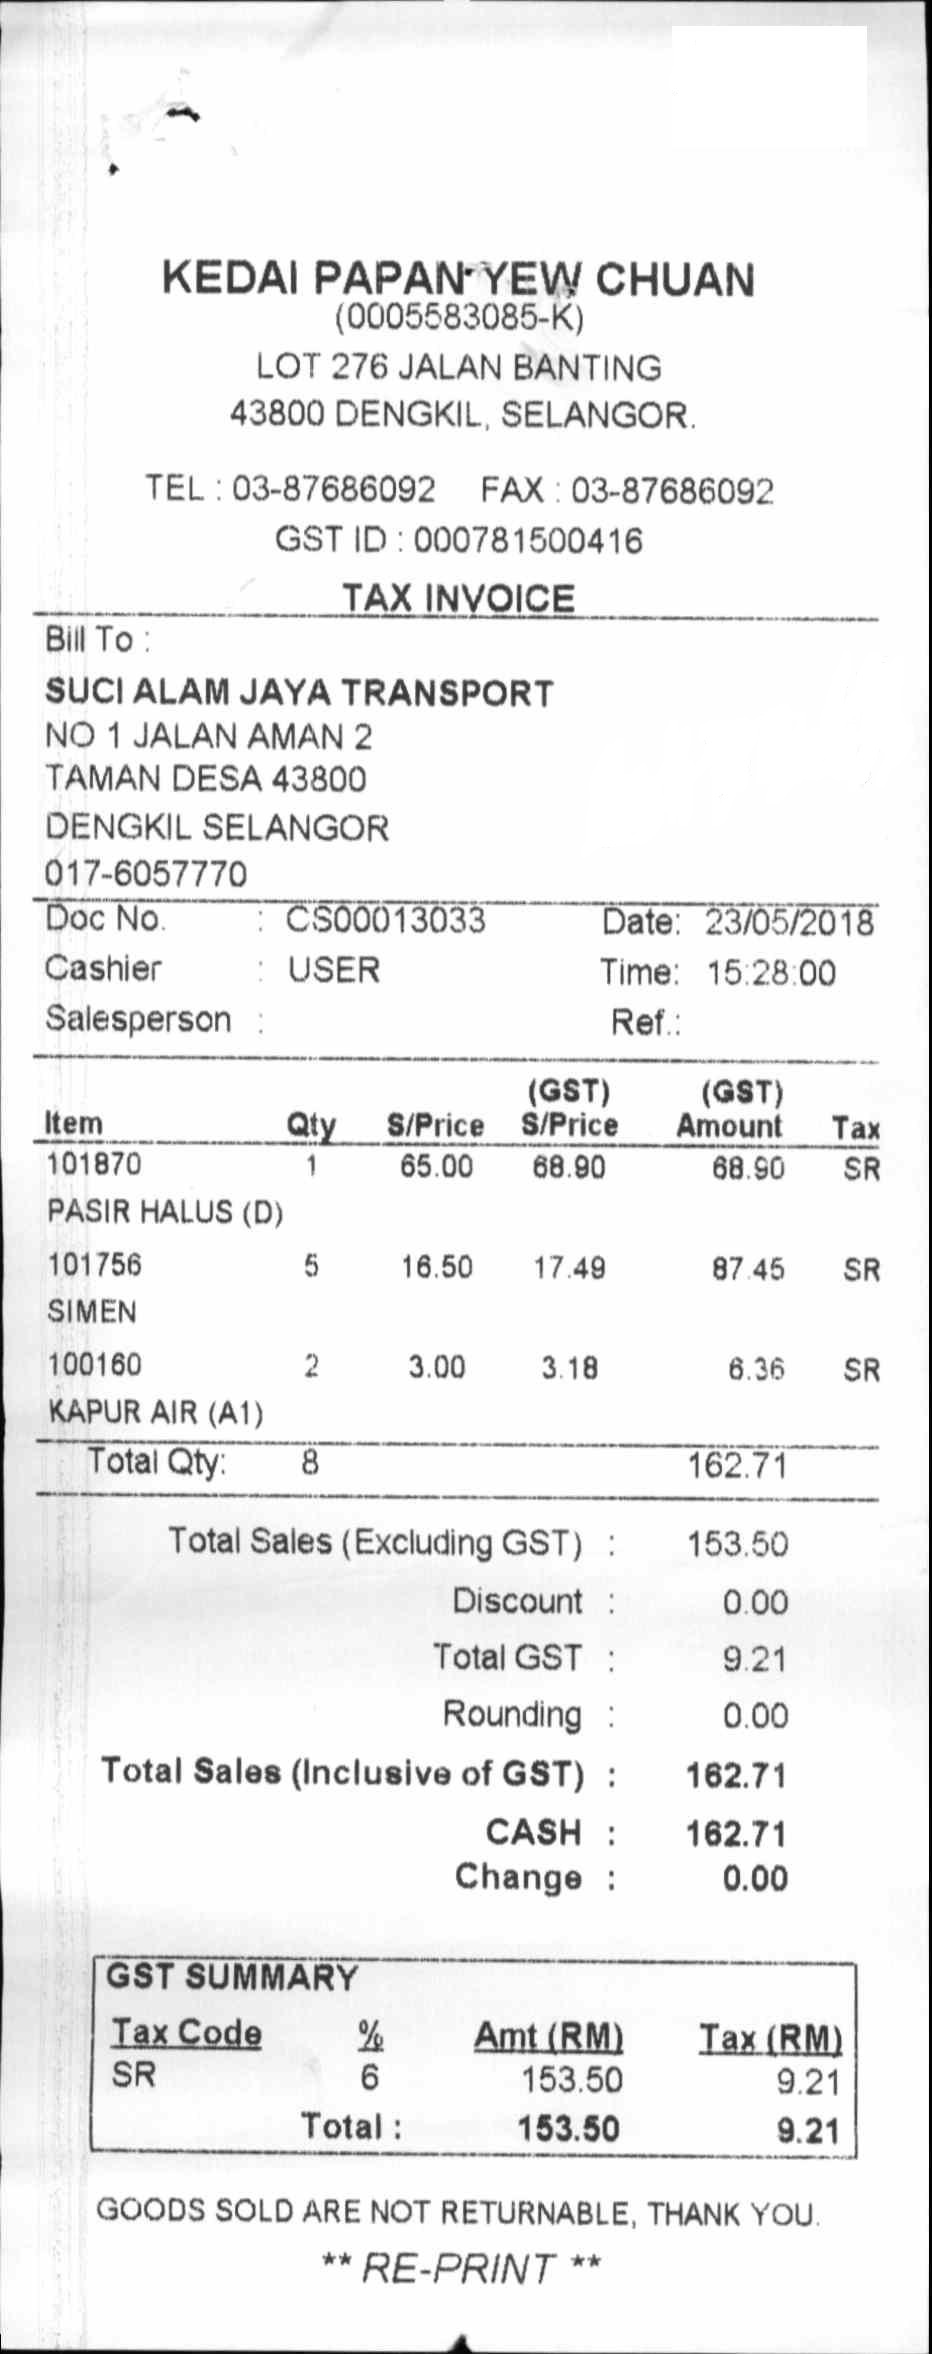

In [5]:
url = os.path.join(image_folder, image_name+image_ext)
image = load_image(url)
image

In [6]:
with open("agent_prompt.txt", "r") as f:
    agent_prompt = f.read()

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": agent_prompt},
        ],
    },
]

In [7]:
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)
outputs = model.generate(**inputs, max_new_tokens=512)
output = processor.batch_decode(outputs, skip_special_tokens=True)[0]
assistant_response = output.split("assistant")[-1].strip()

In [8]:
print(assistant_response)

{
"company": "KEDA PAPAN-YEU CHUAN",
"date": "23/05/2018",
"address": "LOT 26, BANGKOK, THAILAND",
"total": "163.50"
}


In [9]:
with open("validation_prompt.txt", "r") as f:
    validation_prompt = f.read().format(assistant_response=assistant_response)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": validation_prompt},
        ],
    },
]

In [10]:
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model.device)
outputs = model.generate(**inputs, max_new_tokens=512)
output = processor.batch_decode(outputs, skip_special_tokens=True)[0]
validation_assistant_response = output.split("assistant")[-1].strip()

In [11]:
print(validation_assistant_response)

{
  "verdict": "incorrect",
  "issues": [
    "missing_date",
    "total_mismatch"
  ]
}


In [12]:
try:
    if json.loads(validation_assistant_response)['verdict'] == "correct":
        with open("extracted_details.json", "w") as f:
            json.dump(json.loads(assistant_response), f, indent=2)
    else:
        with open("correction_prompt.txt", "r") as f:
            correction_prompt = f.read().format(EXTRACTION_JSON=assistant_response, EVALUATION_JSON=validation_assistant_response)
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": correction_prompt},
                ],
            },
        ]
        inputs = processor.apply_chat_template(
            conversation,
            add_generation_prompt=True,
            return_tensors="pt",
            return_dict=True,
            tokenize=True,
        ).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=512)
        output = processor.batch_decode(outputs, skip_special_tokens=True)[0]
        corrected_assistant_response = output.split("assistant")[-1].strip()
        with open("extracted_details.json", "w") as f:
            json.dump(json.loads(corrected_assistant_response), f, indent=2)
except:
    print("Please try again")